In [1]:
# import useful libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from kneed import KneeLocator
from typing import Tuple
from dataclasses import dataclass
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read Dataset
wafers=pd.read_csv("wafer_23012020_041211.csv")
wafers.head()

,Unnamed: 0,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-6,Sensor-7,Sensor-8,Sensor-9,...,Sensor-582,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,Wafer-801,2968.33,2476.58,2216.7333,1748.0885,1.1127,100.0,97.5822,0.1242,1.5300,...,NaN,0.5004,0.0120,0.0033,2.4069,0.0545,0.0184,0.0055,33.7876,-1
1,Wafer-802,2961.04,2506.43,2170.0666,1364.5157,1.5447,100.0,96.7700,0.1230,1.3953,...,NaN,0.4994,0.0115,0.0031,2.3020,0.0545,0.0184,0.0055,33.7876,1
2,Wafer-803,3072.03,2500.68,2205.7445,1363.1048,1.0518,100.0,101.8644,0.1220,1.3896,...,NaN,0.4987,0.0118,0.0036,2.3719,0.0545,0.0184,0.0055,33.7876,-1
3,Wafer-804,3021.83,2419.83,2205.7445,1363.1048,1.0518,100.0,101.8644,0.1220,1.4108,...,NaN,0.4934,0.0123,0.0040,2.4923,0.0545,0.0184,0.0055,33.7876,-1
4,Wafer-805,3006.95,2435.34,2189.8111,1084.6502,1.1993,100.0,104.8856,0.1234,1.5094,...,NaN,0.4987,0.0145,0.0041,2.8991,0.0545,0.0184,0.0055,33.7876,-1


In [3]:
# create test dataset
wafers.drop(columns=['Unnamed: 0']).iloc[:100].to_csv('test.csv',index=False)

In [4]:
wafers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Columns: 592 entries, Unnamed: 0 to Good/Bad
dtypes: float64(494), int64(97), object(1)
memory usage: 467.3+ KB


In [5]:
wafers.describe()

,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-6,Sensor-7,Sensor-8,Sensor-9,Sensor-10,...,Sensor-582,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
count,100.000000,101.000000,98.000000,98.000000,98.000000,98.0,98.000000,98.000000,101.000000,101.000000,...,34.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,3017.993400,2485.921485,2202.189353,1490.754698,1.185049,100.0,97.363236,0.122218,1.461697,0.000286,...,74.331709,0.499322,0.013624,0.003551,2.729488,0.023375,0.014840,0.004676,77.795167,-0.881188
std,71.790535,67.809173,30.194475,462.949098,0.350921,0.0,5.589615,0.002009,0.070966,0.010566,...,41.857728,0.003482,0.004323,0.000869,0.871736,0.012008,0.007528,0.002515,54.952461,0.475124
min,2825.670000,2254.990000,2114.666700,978.783200,0.753100,100.0,83.423300,0.116000,1.317900,-0.027900,...,20.309100,0.492500,0.007600,0.002100,1.515200,0.009900,0.004800,0.001700,20.309100,-1.000000
25%,2973.300000,2445.200000,2189.966700,1111.543600,0.839150,100.0,94.974725,0.120800,1.408000,-0.006800,...,47.356000,0.497300,0.011300,0.003100,2.276400,0.013400,0.009500,0.002700,33.787600,-1.000000
50%,3005.360000,2493.030000,2200.988900,1254.730700,1.159450,100.0,99.402750,0.122250,1.454200,0.001200,...,65.127550,0.499400,0.012800,0.003400,2.554900,0.021800,0.013900,0.003800,65.036500,-1.000000
75%,3071.295000,2527.200000,2213.211100,1963.801600,1.383000,100.0,101.457800,0.123400,1.507100,0.008100,...,99.419050,0.501500,0.014700,0.003800,2.949800,0.028000,0.019200,0.005900,104.303400,-1.000000
max,3221.210000,2664.520000,2315.266700,2363.641200,2.207300,100.0,107.152200,0.126200,1.641100,0.025000,...,223.101800,0.508700,0.043700,0.008900,8.816000,0.054500,0.040100,0.015000,223.101800,1.000000


In [6]:
wafers.columns.unique()

Index(['Unnamed: 0', 'Sensor-1', 'Sensor-2', 'Sensor-3', 'Sensor-4',
       'Sensor-5', 'Sensor-6', 'Sensor-7', 'Sensor-8', 'Sensor-9',
       ...
       'Sensor-582', 'Sensor-583', 'Sensor-584', 'Sensor-585', 'Sensor-586',
       'Sensor-587', 'Sensor-588', 'Sensor-589', 'Sensor-590', 'Good/Bad'],
      dtype='object', length=592)

In [7]:
# rename Unnamed: 0 to Wafer
wafers.rename(columns={'Unnamed: 0': 'Wafer'},inplace=True)

In [8]:
wafers.head(2)

,Wafer,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-6,Sensor-7,Sensor-8,Sensor-9,...,Sensor-582,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,Wafer-801,2968.33,2476.58,2216.7333,1748.0885,1.1127,100.0,97.5822,0.1242,1.5300,...,NaN,0.5004,0.0120,0.0033,2.4069,0.0545,0.0184,0.0055,33.7876,-1
1,Wafer-802,2961.04,2506.43,2170.0666,1364.5157,1.5447,100.0,96.7700,0.1230,1.3953,...,NaN,0.4994,0.0115,0.0031,2.3020,0.0545,0.0184,0.0055,33.7876,1


In [9]:
# how many wafers is good and how many bad
wafers['Good/Bad'].value_counts()

Good/Bad
-1    95
 1     6
Name: count, dtype: int64

In [10]:
wafers['Good/Bad'].isna().sum()

0

In [11]:
wafers.isna().sum()

Wafer         0
Sensor-1      1
Sensor-2      0
Sensor-3      3
Sensor-4      3
             ..
Sensor-587    0
Sensor-588    0
Sensor-589    0
Sensor-590    0
Good/Bad      0
Length: 592, dtype: int64

In [12]:
wafers

,Wafer,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-6,Sensor-7,Sensor-8,Sensor-9,...,Sensor-582,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,Wafer-801,2968.33,2476.58,2216.7333,1748.0885,1.1127,100.0,97.5822,0.1242,1.5300,...,NaN,0.5004,0.0120,0.0033,2.4069,0.0545,0.0184,0.0055,33.7876,-1
1,Wafer-802,2961.04,2506.43,2170.0666,1364.5157,1.5447,100.0,96.7700,0.1230,1.3953,...,NaN,0.4994,0.0115,0.0031,2.3020,0.0545,0.0184,0.0055,33.7876,1
2,Wafer-803,3072.03,2500.68,2205.7445,1363.1048,1.0518,100.0,101.8644,0.1220,1.3896,...,NaN,0.4987,0.0118,0.0036,2.3719,0.0545,0.0184,0.0055,33.7876,-1
3,Wafer-804,3021.83,2419.83,2205.7445,1363.1048,1.0518,100.0,101.8644,0.1220,1.4108,...,NaN,0.4934,0.0123,0.0040,2.4923,0.0545,0.0184,0.0055,33.7876,-1
4,Wafer-805,3006.95,2435.34,2189.8111,1084.6502,1.1993,100.0,104.8856,0.1234,1.5094,...,NaN,0.4987,0.0145,0.0041,2.8991,0.0545,0.0184,0.0055,33.7876,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Wafer-897,2982.87,2477.01,2315.2667,2360.1325,1.1259,100.0,90.1144,0.1160,1.4695,...,NaN,0.5003,0.0106,0.0028,2.1263,0.0153,0.0048,0.0017,31.0176,1
97,Wafer-898,3084.82,2387.42,2171.5000,1028.4440,0.7899,100.0,101.5122,0.1224,1.3603,...,NaN,0.5016,0.0130,0.0028,2.5865,0.0153,0.0048,0.0017,31.0176,-1
98,Wafer-899,2955.87,2541.89,NaN,NaN,NaN,NaN,NaN,NaN,1.4493,...,NaN,0.5023,0.0140,0.0033,2.7810,0.0153,0.0048,0.0017,31.0176,-1
99,Wafer-900,2914.86,2465.11,2210.2778,2120.5760,1.0700,100.0,95.1089,0.1230,1.5817,...,NaN,0.5026,0.0121,0.0032,2.4064,0.0153,0.0048,0.0017,31.0176,1


In [13]:
wafers.isna().sum().sum()

2338

In [14]:
## Check missing values in dependent feature variables
wafers.isna().sum().sum() / (wafers.shape[0]*(wafers.shape[1]-1))

0.03916838384346049

In [15]:
mylist=[1,2,3,4,5]
for i in enumerate(mylist):
    print(i)

(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 5)


In [16]:
# for background plot color
plt.style.use('dark_background')

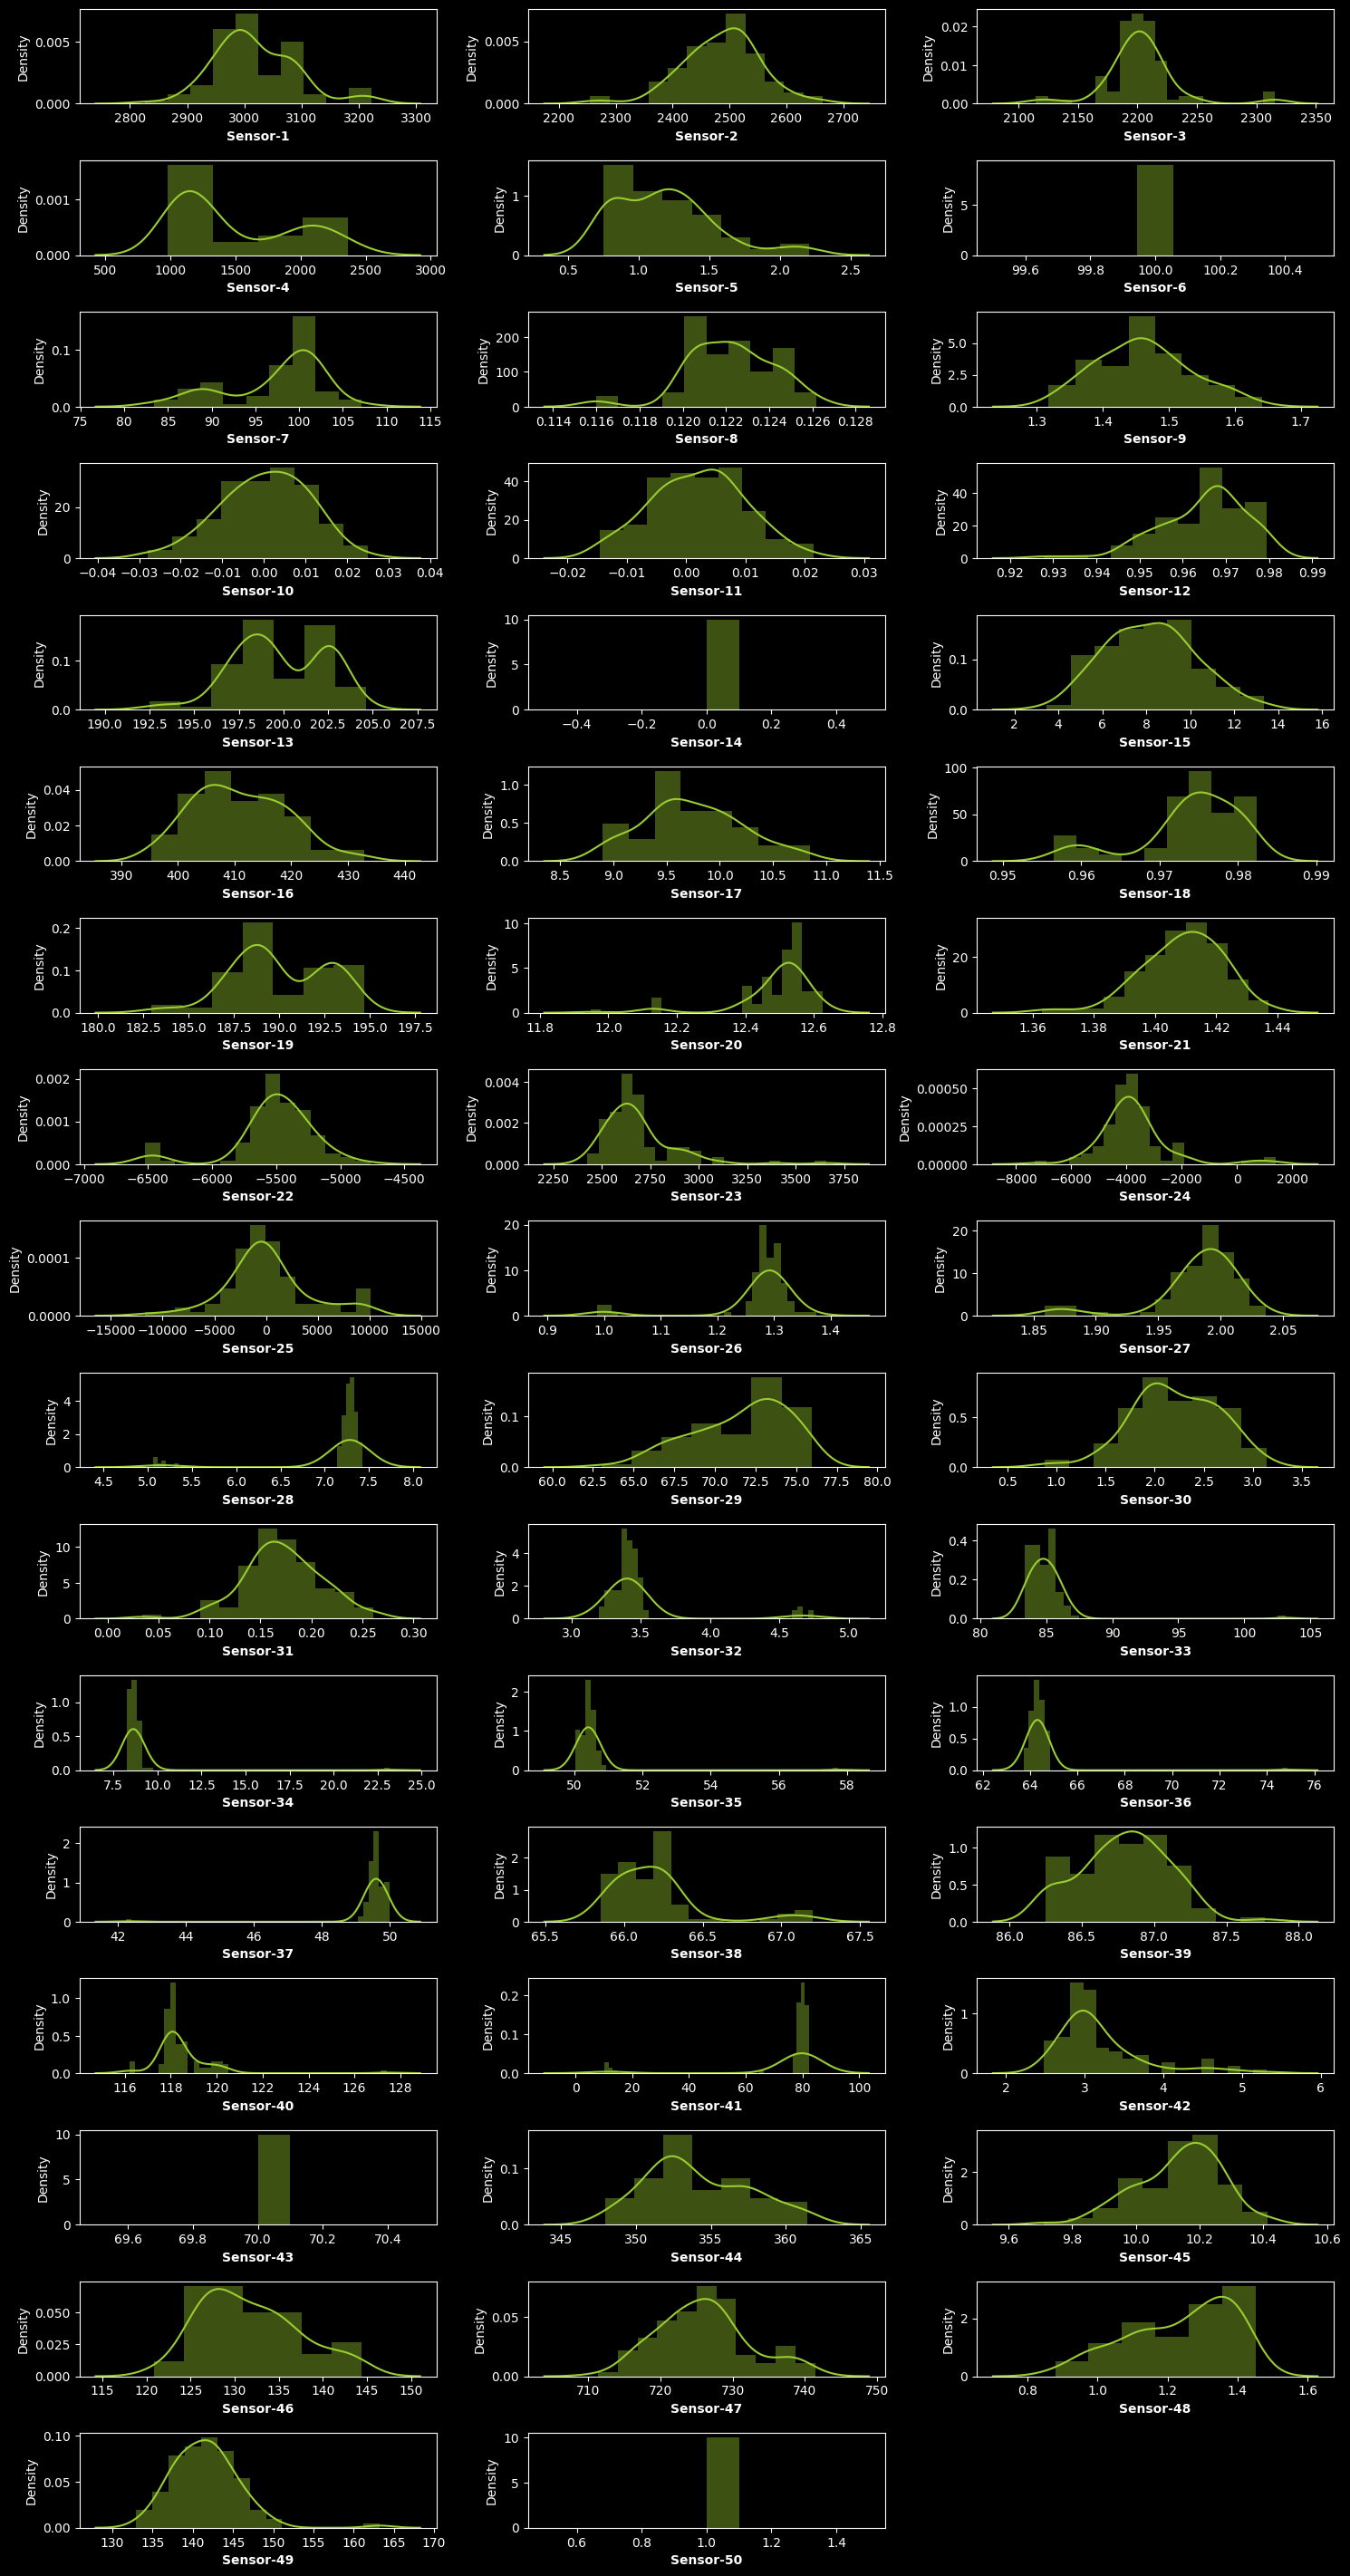

In [17]:
# let's have a look at the distribution first 50 sensors of Wafers
plt.figure(figsize=(15,100))

for i, col in enumerate(wafers.columns[1:51]):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=wafers[col], color='yellowgreen')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

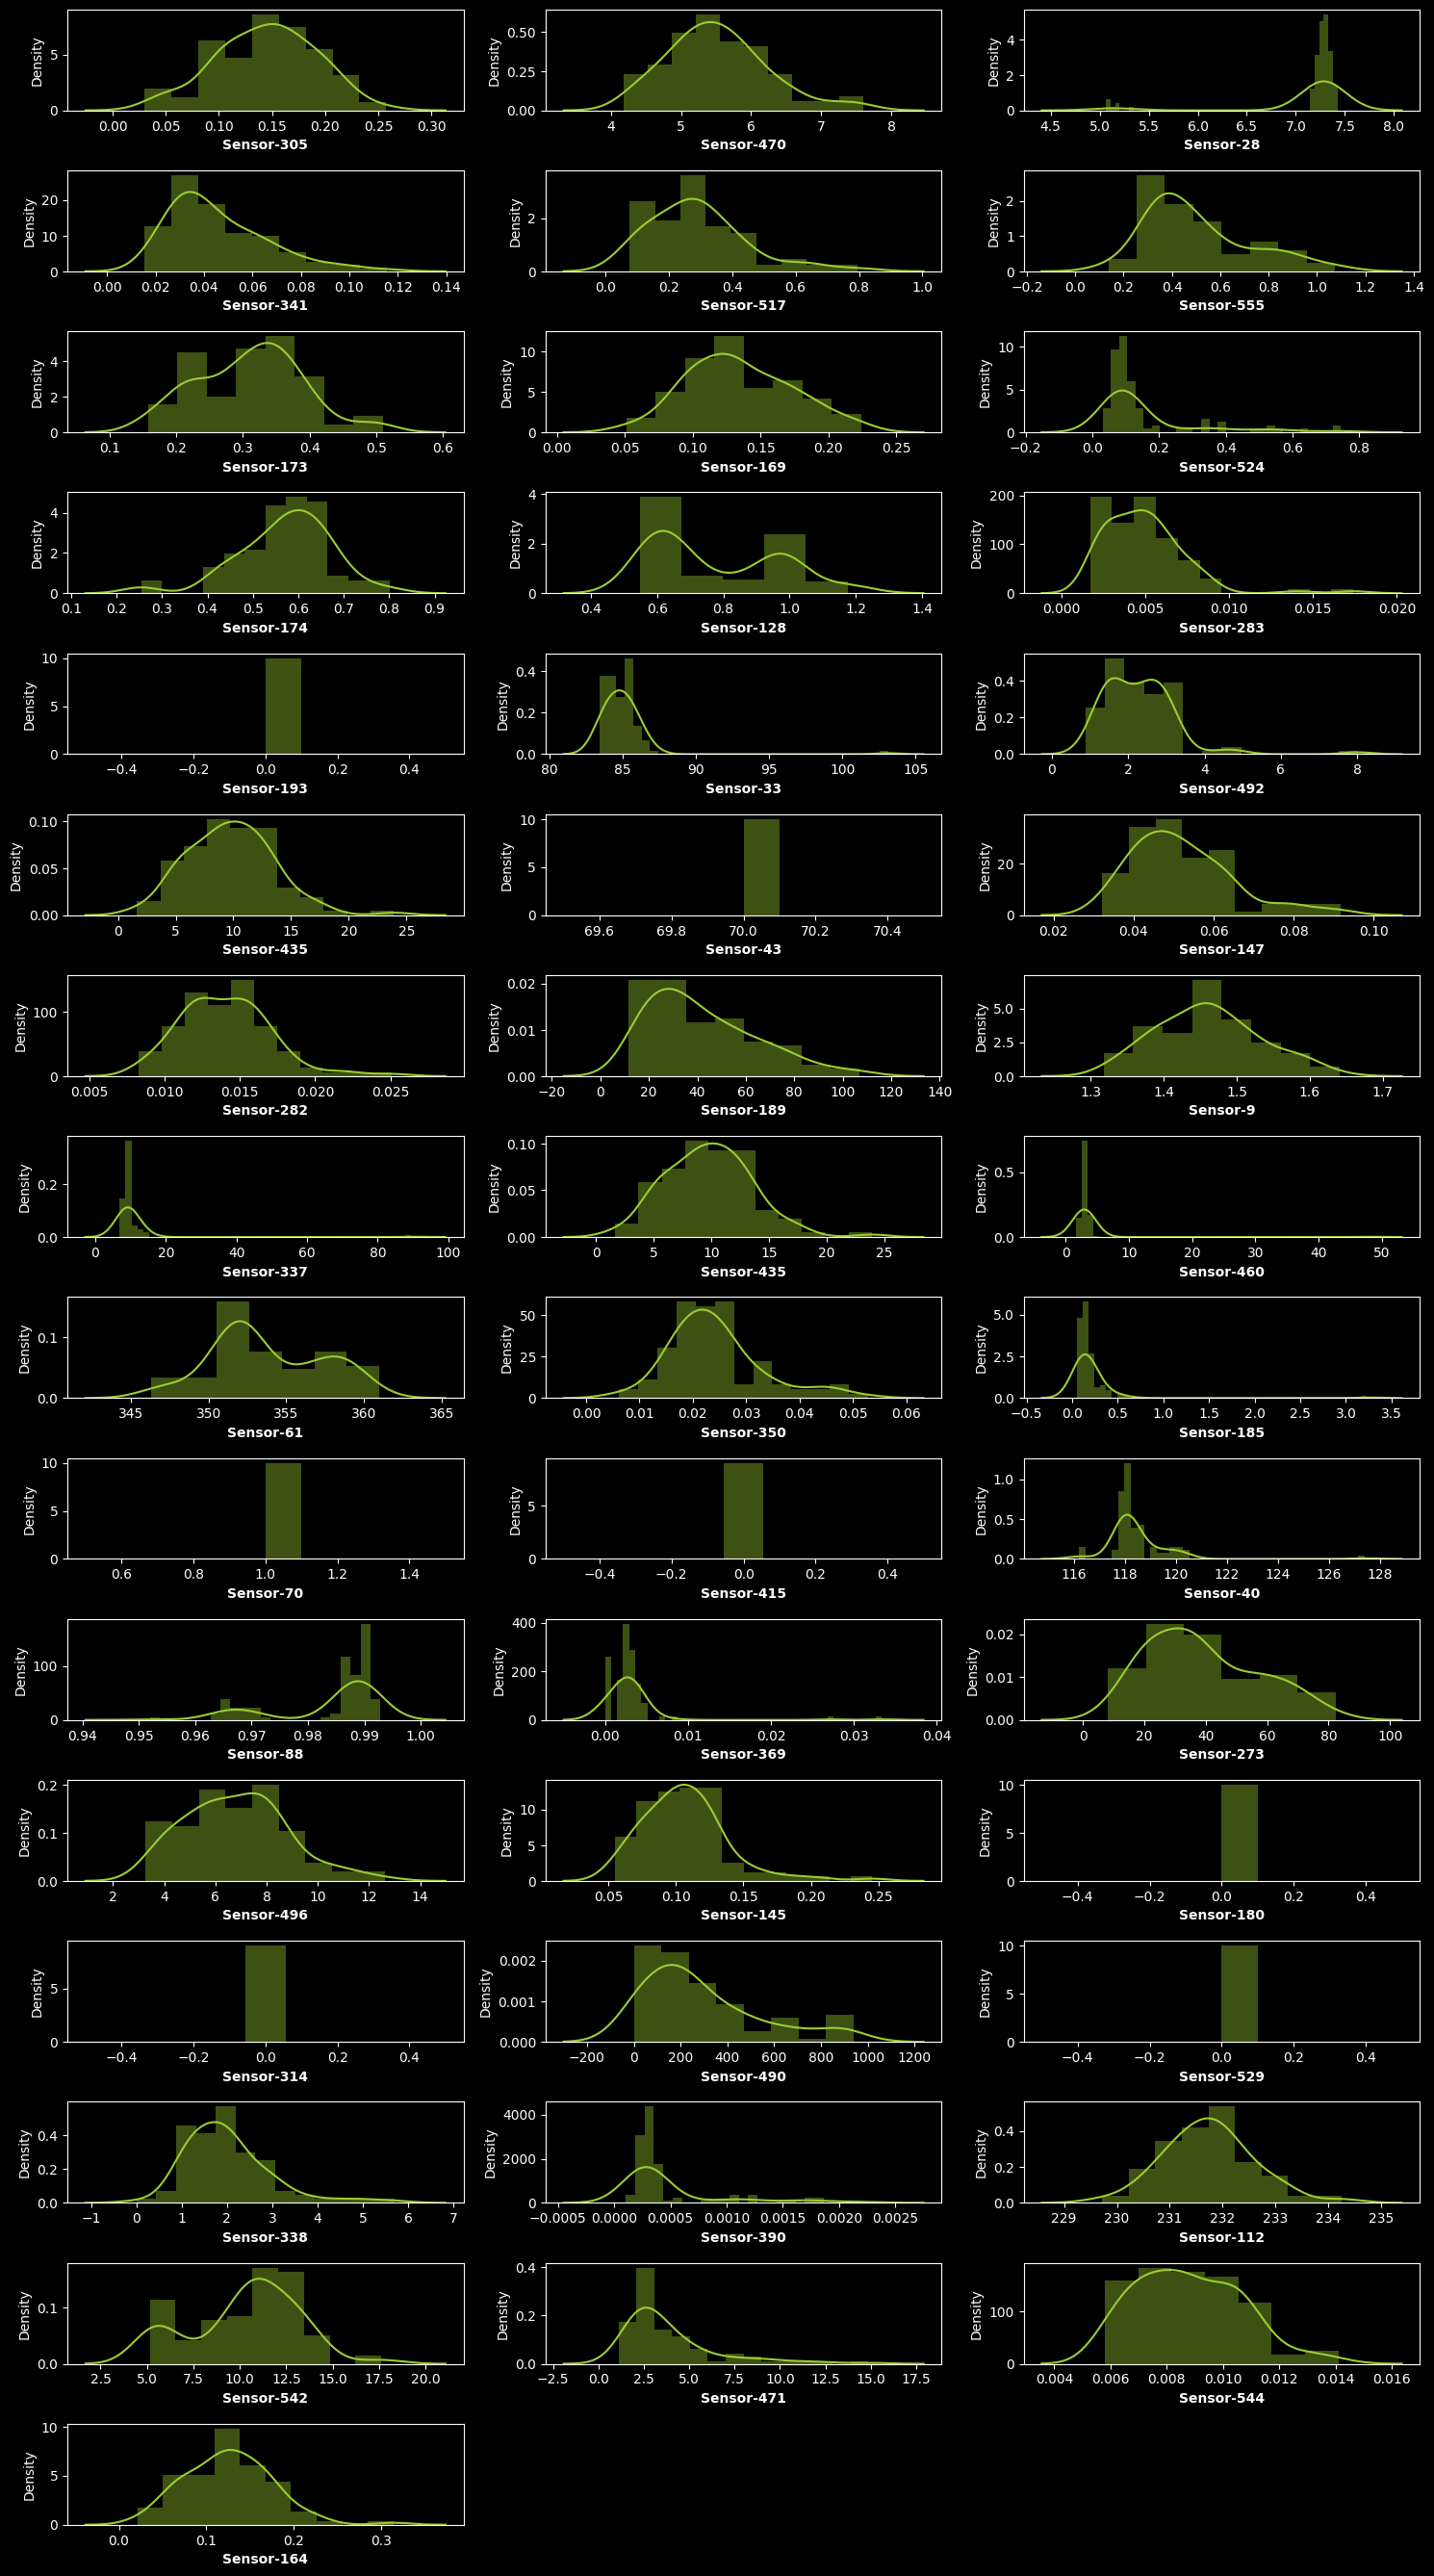

In [18]:
# Select 50 random sensors
random_50_sensors_idx = []
for i in range(50):
    if i not in random_50_sensors_idx:
        random_50_sensors_idx.append(np.random.randint(1,591))

# let's now, have a look at the distribution of random 50 sensors        
plt.figure(figsize=(15,100))

for i, col in enumerate(wafers.columns[random_50_sensors_idx]):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=wafers[col], color='yellowgreen')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

In [19]:
wafers.isna().sum()

Wafer         0
Sensor-1      1
Sensor-2      0
Sensor-3      3
Sensor-4      3
             ..
Sensor-587    0
Sensor-588    0
Sensor-589    0
Sensor-590    0
Good/Bad      0
Length: 592, dtype: int64

In [20]:
wafers.shape

(101, 592)

In [21]:
wafers.shape[0]

101

In [22]:
wafers.isna().sum().div(wafers.shape[0])>.7

Wafer         False
Sensor-1      False
Sensor-2      False
Sensor-3      False
Sensor-4      False
              ...  
Sensor-587    False
Sensor-588    False
Sensor-589    False
Sensor-590    False
Good/Bad      False
Length: 592, dtype: bool

In [23]:
def get_cols_with_zero_std_dev(df: pd.DataFrame):
    """
    Returns a list of columns names who are having zero standard deviation.
    """
    cols_to_drop = []
    num_cols = [col for col in df.columns if df[col].dtype != 'O']  # numerical cols only
    for col in num_cols:
        if df[col].std() == 0:
            cols_to_drop.append(col)
    return cols_to_drop

def get_redundant_cols(df: pd.DataFrame, missing_thresh=.7):
    """
    Returns a list of columns having missing values more than certain thresh.
    """
    cols_missing_ratios = df.isna().sum().div(df.shape[0])
    cols_to_drop = list(cols_missing_ratios[cols_missing_ratios > missing_thresh].index)
    return cols_to_drop 

In [24]:
## Columns wafers missing values more than 70%
cols_to_drop_1 = get_redundant_cols(wafers, missing_thresh=.7)
cols_to_drop_1

['Sensor-158', 'Sensor-159', 'Sensor-293', 'Sensor-294']

In [25]:
## Columns wafers 0 Standard Deviation
cols_to_drop_2 = get_cols_with_zero_std_dev(wafers)
cols_to_drop_2.append("Wafer")
cols_to_drop_2

['Sensor-6',
 'Sensor-14',
 'Sensor-43',
 'Sensor-50',
 'Sensor-53',
 'Sensor-70',
 'Sensor-75',
 'Sensor-98',
 'Sensor-142',
 'Sensor-150',
 'Sensor-179',
 'Sensor-180',
 'Sensor-187',
 'Sensor-190',
 'Sensor-191',
 'Sensor-192',
 'Sensor-193',
 'Sensor-194',
 'Sensor-195',
 'Sensor-207',
 'Sensor-210',
 'Sensor-227',
 'Sensor-230',
 'Sensor-231',
 'Sensor-232',
 'Sensor-233',
 'Sensor-234',
 'Sensor-235',
 'Sensor-236',
 'Sensor-237',
 'Sensor-238',
 'Sensor-241',
 'Sensor-242',
 'Sensor-243',
 'Sensor-244',
 'Sensor-257',
 'Sensor-258',
 'Sensor-259',
 'Sensor-260',
 'Sensor-261',
 'Sensor-262',
 'Sensor-263',
 'Sensor-264',
 'Sensor-265',
 'Sensor-266',
 'Sensor-267',
 'Sensor-277',
 'Sensor-285',
 'Sensor-314',
 'Sensor-315',
 'Sensor-316',
 'Sensor-323',
 'Sensor-326',
 'Sensor-327',
 'Sensor-328',
 'Sensor-329',
 'Sensor-330',
 'Sensor-331',
 'Sensor-343',
 'Sensor-348',
 'Sensor-365',
 'Sensor-370',
 'Sensor-371',
 'Sensor-372',
 'Sensor-373',
 'Sensor-374',
 'Sensor-375',
 'Se

In [26]:
# columns to drop
cols_to_drop = cols_to_drop_1 + cols_to_drop_2 

In [27]:
# Separate features and Labels out
X, y = wafers.drop(cols_to_drop, axis=1), wafers[["Good/Bad"]]

# Dependent feature variables
print("Shape of the feature now: ", X.shape)
X.head

Shape of the feature now:  (101, 465)


<bound method NDFrame.head of      Sensor-1  Sensor-2   Sensor-3   Sensor-4  Sensor-5  Sensor-7  Sensor-8  \
0     2968.33   2476.58  2216.7333  1748.0885    1.1127   97.5822    0.1242   
1     2961.04   2506.43  2170.0666  1364.5157    1.5447   96.7700    0.1230   
2     3072.03   2500.68  2205.7445  1363.1048    1.0518  101.8644    0.1220   
3     3021.83   2419.83  2205.7445  1363.1048    1.0518  101.8644    0.1220   
4     3006.95   2435.34  2189.8111  1084.6502    1.1993  104.8856    0.1234   
..        ...       ...        ...        ...       ...       ...       ...   
96    2982.87   2477.01  2315.2667  2360.1325    1.1259   90.1144    0.1160   
97    3084.82   2387.42  2171.5000  1028.4440    0.7899  101.5122    0.1224   
98    2955.87   2541.89        NaN        NaN       NaN       NaN       NaN   
99    2914.86   2465.11  2210.2778  2120.5760    1.0700   95.1089    0.1230   
100   3086.52   2360.04  2204.2333  2110.8288    1.6392   89.0356    0.1245   

     Sensor-9  Sensor

In [28]:
# Independent/Target Variables
print("Shape of the labels: ", y.shape)
y.head

Shape of the labels:  (101, 1)


<bound method NDFrame.head of      Good/Bad
0          -1
1           1
2          -1
3          -1
4          -1
..        ...
96          1
97         -1
98         -1
99          1
100        -1

[101 rows x 1 columns]>

In [29]:
imputer = KNNImputer(n_neighbors=3)
preprocessing_pipeline = Pipeline(
steps=[('Imputer', imputer), ('Scaler', RobustScaler())])
preprocessing_pipeline

Pipeline(steps=[('Imputer', KNNImputer(n_neighbors=3)),
                ('Scaler', RobustScaler())])

In [30]:
# Transform "Wafers" features
X_trans = preprocessing_pipeline.fit_transform(X)
print("Shape of transformed features set: ", X_trans.shape)
X_trans

Shape of transformed features set:  (101, 465)


array([[-0.36988409, -0.20060976,  0.67734164, ...,  0.53125   ,
        -0.44314749,  0.        ],
       [-0.44466099,  0.16341463, -1.33031182, ...,  0.53125   ,
        -0.44314749,  2.        ],
       [ 0.69381475,  0.09329268,  0.20459121, ...,  0.53125   ,
        -0.44314749,  0.        ],
       ...,
       [-0.49769207,  0.59585366, -0.16379859, ..., -0.65625   ,
        -0.48242947,  0.        ],
       [-0.9183506 , -0.3404878 ,  0.39961883, ..., -0.65625   ,
        -0.48242947,  2.        ],
       [ 0.84244538, -1.62182927,  0.1395777 , ...,  0.        ,
         0.69844347,  0.        ]])

In [31]:
# clustring 
@dataclass
class ClusterDataInstances:
    
    X: np.array
    desc: str

    def _get_ideal_number_of_clusters(self):
        
        try:
            print(
                f'Getting the ideal number of clusters to cluster "{self.desc} set" into..')

            ####################### Compute WCSS for shortlisted number of clusters ##########################
            print("computing WCSS for shortlisted number of clusters..")
            wcss = []  # Within Summation of Squares
            for i in range(1, 11):
                kmeans = KMeans(n_clusters=i, init='k-means++',
                                random_state=42)
                kmeans.fit(self.X)
                wcss.append(kmeans.inertia_)
                print(f"WCSS for n_clusters={i}: {kmeans.inertia_}")
            print(
                "WCSS computed successfully for all shortlisted number of clusters!")

            ################### Finalize dispersal point as the ideal number of clusters #####################
            print(
                "Finding the ideal number of clusters (by locating the dispersal point) via Elbow method..")
            knee_finder = KneeLocator(
                range(1, 11), wcss, curve='convex', direction='decreasing')  # range(1, 11) vs WCSS
            print(
                f"Ideal number of clusters to be formed: {knee_finder.knee}")

            return knee_finder.knee
            ...
        except Exception as e:
            print(e)
            raise e

    def create_clusters(self) -> Tuple:
        
        try:
            ideal_clusters = self._get_ideal_number_of_clusters()
            print(
                f"Dividing the \"{self.desc}\" instances into {ideal_clusters} clusters via KMeans Clustering algorithm..")
            kmeans = KMeans(n_clusters=ideal_clusters,
                            init='k-means++', random_state=42)
            y_kmeans = kmeans.fit_predict(self.X)
            print(
                f"..said data instances divided into {ideal_clusters} clusters successfully!")

            return kmeans, np.c_[self.X, y_kmeans]
            ...
        except Exception as e:
            print(e)
            raise e

In [32]:
# Cluster `Wafer` instances
cluster_wafers = ClusterDataInstances(X=X_trans, desc="wafers features")
clusterer, X_clus = cluster_wafers.create_clusters()
X_clus

Getting the ideal number of clusters to cluster "wafers features set" into..
computing WCSS for shortlisted number of clusters..
WCSS for n_clusters=1: 9781300.67561968
WCSS for n_clusters=2: 2475781.764980524
WCSS for n_clusters=3: 1487797.7538446232
WCSS for n_clusters=4: 757773.7776145439
WCSS for n_clusters=5: 419526.678384271
WCSS for n_clusters=6: 321472.996455219
WCSS for n_clusters=7: 262560.2821507529
WCSS for n_clusters=8: 219896.47422566632
WCSS for n_clusters=9: 191053.80408683547
WCSS for n_clusters=10: 149162.16451231984
WCSS computed successfully for all shortlisted number of clusters!
Finding the ideal number of clusters (by locating the dispersal point) via Elbow method..
Ideal number of clusters to be formed: 2
Dividing the "wafers features" instances into 2 clusters via KMeans Clustering algorithm..
..said data instances divided into 2 clusters successfully!


array([[-0.36988409, -0.20060976,  0.67734164, ..., -0.44314749,
         0.        ,  0.        ],
       [-0.44466099,  0.16341463, -1.33031182, ..., -0.44314749,
         2.        ,  0.        ],
       [ 0.69381475,  0.09329268,  0.20459121, ..., -0.44314749,
         0.        ,  1.        ],
       ...,
       [-0.49769207,  0.59585366, -0.16379859, ..., -0.48242947,
         0.        ,  0.        ],
       [-0.9183506 , -0.3404878 ,  0.39961883, ..., -0.48242947,
         2.        ,  0.        ],
       [ 0.84244538, -1.62182927,  0.1395777 , ...,  0.69844347,
         0.        ,  0.        ]])

In [33]:
# Clusters
np.unique(X_clus[:, -1])

array([0., 1.])

In [34]:
## Configure "Clustered" array along with target features
wafers_clus = np.c_[X_clus, y]
# Cluster_1 data
wafers_1 = wafers_clus[wafers_clus[:, -2] == 0]
wafers_1.shape

(77, 467)

In [35]:
# Cluster_2 data
wafers_clus[wafers_clus[:, -2] == 1].shape

(24, 467)

In [36]:
# CLuster_3 data
wafers_clus[wafers_clus[:, -2] == 2].shape

(0, 467)

In [37]:
X, y = X_trans[:, :-1], y
resampler = SMOTETomek(sampling_strategy="auto")
X_res, y_res = resampler.fit_resample(X, y)

In [38]:
print("Before resampling, Shape of training instances: ", np.c_[X, y].shape)
print("After resampling, Shape of training instances: ", np.c_[X_res, y_res].shape)

Before resampling, Shape of training instances:  (101, 465)
After resampling, Shape of training instances:  (190, 465)


In [39]:
# Target Cats after Resampling
print(np.unique(y_res))
print(f"Value Counts: \n-1: {len(y_res[y_res == -1])}, 1: {len(y_res[y_res ==1])}")

[-1  1]
Value Counts: 
-1: 190, 1: 190


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=1/3, random_state=42)
print(f"train set: {X_train.shape, y_train.shape}")
print(f"test set: {X_test.shape, y_test.shape}")

train set: ((126, 464), (126, 1))
test set: ((64, 464), (64, 1))


In [41]:
# Prepared training and test sets
X_prep = X_train
y_prep = y_train
X_test_prep = X_test
y_test_prep = y_test
print(X_prep.shape, y_prep.shape)
print(X_test_prep.shape, y_test_prep.shape)

(126, 464) (126, 1)
(64, 464) (64, 1)


In [42]:
#Shortlisted base Models
svc_clf = SVC(kernel='linear')
svc_rbf_clf = SVC(kernel='rbf')
random_clf = RandomForestClassifier(random_state=42)
xgb_clf = XGBClassifier(objective='binary:logistic')

In [43]:
# A function to display Scores
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

In [44]:
# SVC Scores
svc_scores = cross_val_score(svc_clf, X_prep, y_prep, scoring='roc_auc', cv=10,verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [45]:
display_scores(svc_scores)

Scores:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean:  1.0
Standard Deviation:  0.0


In [46]:
## Performance on test set using cross-validation
# Predictions using cross-validation
svc_preds = cross_val_predict(svc_clf, X_test_prep, y_test_prep, cv=5)
# AUC score
svc_auc = roc_auc_score(y_test_prep, svc_preds)
svc_auc

0.9696969696969697

In [47]:
## SVC rbf Scores
svc_rbf_scores = cross_val_score(svc_rbf_clf, X_prep, y_prep,scoring='roc_auc', cv=10, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [48]:
display_scores(svc_rbf_scores)

Scores:  [0.92857143 1.         0.92857143 0.9047619  1.         0.92857143
 0.97222222 0.88888889 0.86111111 1.        ]
Mean:  0.9412698412698413
Standard Deviation:  0.047213884818209026


In [49]:
## Performance on test set using cross-validation
# Predictions using cross-validation
svc_rbf_preds = cross_val_predict(svc_rbf_clf, X_test_prep, y_test_prep, cv=5)
# AUC score
svc_rbf_auc = roc_auc_score(y_test_prep, svc_rbf_preds)
svc_rbf_auc

0.6363636363636364

In [50]:
## Random Forest Scores
random_clf_scores = cross_val_score(random_clf, X_prep, y_prep,scoring='roc_auc', cv=10, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished


In [51]:
display_scores(random_clf_scores)

Scores:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean:  1.0
Standard Deviation:  0.0


In [52]:
## Performance on test set using cross-validation
# Predictions using cross-validation
random_clf_preds = cross_val_predict(random_clf, X_test_prep, y_test_prep, cv=5)
# AUC score
random_clf_auc = roc_auc_score(y_test_prep, random_clf_preds)
random_clf_auc

1.0